#### **Question 1: Adapt the given code to work on the English <-> Italian dataset you used for previous assignment (i.e. ita-eng.zip from https://www.manythings.org/anki/)**

In [49]:
 %matplotlib inline

In [26]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
header_list = ["eng", "ita", "data"]

df = pd.read_csv("ita.txt",sep='\t', names = header_list)

df=df[['eng','ita']]
eng_ita=df.sample(frac=1.0, replace=True)
eng_ita.to_csv('eng_ita.tsv', sep ='\t', index=False)

In [28]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [29]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [30]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('%s_%s.tsv' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [31]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [32]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'ita', True)
print(random.choice(pairs))

Reading lines...
Read 343814 sentence pairs
Trimmed to 31390 sentence pairs
Counting words...
Counted words:
ita 4809
eng 2895
['io sono una disegnatrice .', 'i m a cartoonist .']


In [33]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [34]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [35]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [36]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [56]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [38]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [39]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [40]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [41]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [42]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

1m 36s (- 22m 26s) (5000 6%) 2.8611
3m 10s (- 20m 40s) (10000 13%) 2.2065
4m 45s (- 19m 3s) (15000 20%) 1.8455
6m 22s (- 17m 31s) (20000 26%) 1.6226
7m 59s (- 15m 59s) (25000 33%) 1.4105
9m 35s (- 14m 23s) (30000 40%) 1.2336
11m 12s (- 12m 48s) (35000 46%) 1.0987
12m 49s (- 11m 13s) (40000 53%) 0.9768
14m 25s (- 9m 37s) (45000 60%) 0.8886
16m 2s (- 8m 1s) (50000 66%) 0.8149
17m 41s (- 6m 25s) (55000 73%) 0.7140
19m 18s (- 4m 49s) (60000 80%) 0.6550
20m 55s (- 3m 13s) (65000 86%) 0.6240
22m 34s (- 1m 36s) (70000 93%) 0.5550
24m 12s (- 0m 0s) (75000 100%) 0.5174


<Figure size 432x288 with 0 Axes>

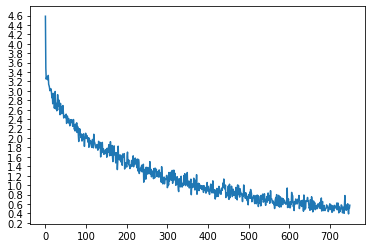

In [53]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [44]:
evaluateRandomly(encoder1, attn_decoder1)

> io sto interferendo .
= i m interfering .
< i m interfering . <EOS>

> voi siete eloquenti .
= you re eloquent .
< you re eloquent . <EOS>

> siete parcheggiati al mio posto .
= you re parked in my spot .
< you re parked in my spot . <EOS>

> non siamo molto buoni .
= we re not very good .
< we re not very good . <EOS>

> hai completamente torto .
= you are completely wrong .
< you are wrong wrong . <EOS>

> io sono il tuo cameriere .
= i m your waiter .
< i m your chaperone . <EOS>

> sono a tre ore di distanza .
= i m three hours away .
< i m three to an innocent . . . <EOS>

> e il prossimo in fila per la promozione .
= you are the next in line for promotion .
< you are the next for line for promotion . <EOS>

> e un ragazzo cosi difficile .
= he is such a difficult boy .
< he is such a cutie boy . <EOS>

> mi fa piacere che abbia funzionato .
= i m glad that worked .
< i am glad you came am . <EOS>



In [ ]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "noi stiamo leggendo")
plt.matshow(attentions.numpy())

input = lui e il miglior giocatore della nostra squadra 
output = he is our best man on . <EOS>


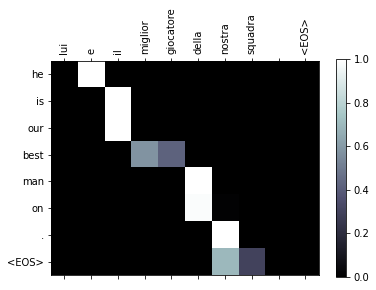

input = sono sicura che voi siete molto occupati .
output = i m sure you re very busy . <EOS>


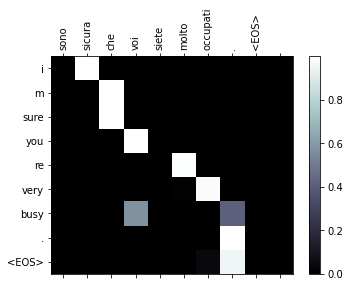

input = e seduto sulla sedia .
output = she is sitting in the chair . <EOS>


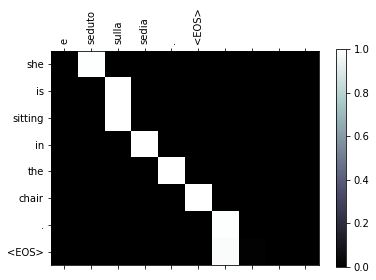

input = lei e creativo .
output = you re creative . <EOS>


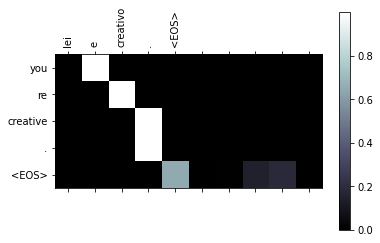

In [50]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("lui e il miglior giocatore della nostra squadra ")

evaluateAndShowAttention("sono sicura che voi siete molto occupati .")

evaluateAndShowAttention("e seduto sulla sedia .")

evaluateAndShowAttention("lei e creativo .")

#### **Question 2:  Refine your model by adding either (a) more layers or (b) more hidden units. Compare the training time and results. Run at least one additional experiment.** 

1m 38s (- 23m 5s) (5000 6%) 0.5586
3m 14s (- 21m 3s) (10000 13%) 0.5375
4m 53s (- 19m 32s) (15000 20%) 0.4977
6m 32s (- 17m 59s) (20000 26%) 0.4921
8m 12s (- 16m 24s) (25000 33%) 0.4621
9m 51s (- 14m 46s) (30000 40%) 0.4644
11m 31s (- 13m 9s) (35000 46%) 0.4049
13m 9s (- 11m 30s) (40000 53%) 0.4049
14m 49s (- 9m 52s) (45000 60%) 0.3744
16m 28s (- 8m 14s) (50000 66%) 0.3859
18m 9s (- 6m 36s) (55000 73%) 0.3732
19m 52s (- 4m 58s) (60000 80%) 0.3485
21m 34s (- 3m 19s) (65000 86%) 0.3482
23m 16s (- 1m 39s) (70000 93%) 0.3152
24m 58s (- 0m 0s) (75000 100%) 0.3176


<Figure size 432x288 with 0 Axes>

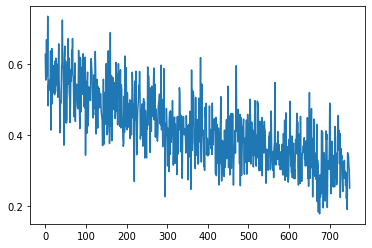

In [57]:
teacher_forcing_ratio = 0.1
hidden_size = 356
encoder2 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder2 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [58]:
evaluateRandomly(encoder1, attn_decoder1)

> tu sei duro .
= you re harsh .
< you re harsh . <EOS>

> lei sta lavando la macchina .
= she is washing the car .
< she is washing the car . <EOS>

> non sto studiando ora .
= i am not studying now .
< i am not studying now . <EOS>

> si sta nascondendo nell armadio .
= he s hiding in the closet .
< he s hiding in the other . <EOS>

> loro sono pronti per te .
= they re ready for you .
< they re ready for you . <EOS>

> voi siete piu che i benvenuti a venire .
= you re more than welcome to come .
< you re more than welcome to come . <EOS>

> verro con te .
= i m going to go with you .
< i m going to get mary . <EOS>

> sto andando alla grande .
= i m doing great .
< i m doing great . <EOS>

> voi siete affidabili .
= you re reliable .
< you re dependable . <EOS>

> e mia .
= she s mine .
< you re mine . <EOS>



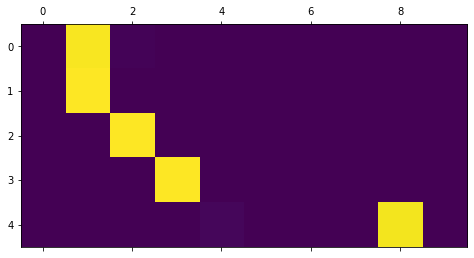

In [59]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "noi stiamo leggendo")
plt.matshow(attentions.numpy())

input = lui e il miglior giocatore della nostra squadra 
output = he s the best of teaching . <EOS>


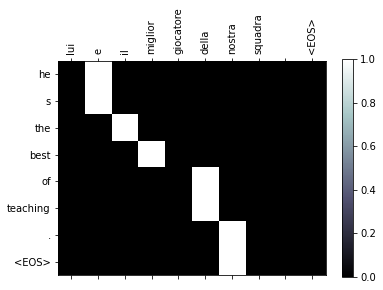

input = sono sicura che voi siete molto occupati .
output = i m sure you re very busy . <EOS>


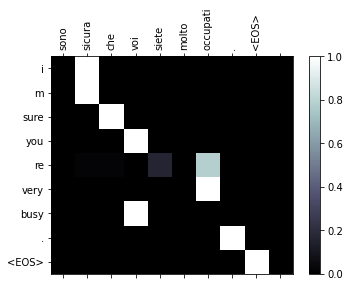

input = e seduto sulla sedia .
output = he is sitting on the chair . <EOS>


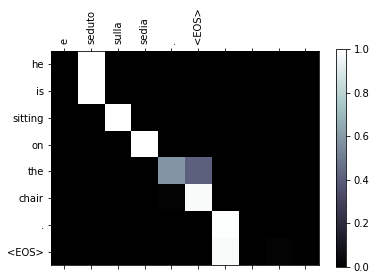

input = lei e creativo .
output = you re creative . <EOS>


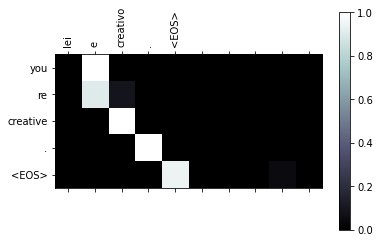

In [60]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("lui e il miglior giocatore della nostra squadra ")

evaluateAndShowAttention("sono sicura che voi siete molto occupati .")

evaluateAndShowAttention("e seduto sulla sedia .")

evaluateAndShowAttention("lei e creativo .")

#### **Question 3:  What do you observe based on your implementation for Question 2?**

I have changed the hidden units as well as teacher_forcing_ratio to a very less value(0.1) so that the model uses its own predictions as the next input. So after re-running the model and the other cells below it, I have observed that the translation is not done properly. Even I have increased the hidden_size but translations are not working properly. This is because it can't feed the target as the next input, thus it enforces to detach from history as the input. Thus due to this, the evaluations are also not done properly, thus it results in bad plots as the outcome. This is the observation that I have observed after changing the teacher_forcing_ratio and the hidden size in the network.